In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [2]:
import autoencoder.aecExtraFeatures as Z_calculations

def addZToPrediction(model, data_point):
    encoded = model.encoder(data_point)
    reconstruction = model.decoder(encoded)

    Z_features = [Z_calculations.getZVector(data_point, reconstruction, encoded)]

    Z_features_tensor = tf.convert_to_tensor(Z_features, dtype=tf.float32)
    data_point = tf.convert_to_tensor(data_point, dtype=tf.float32)

    data_point = tf.concat([data_point, Z_features_tensor], 1)

    return data_point

In [3]:
def isAnomaly(data_point, model_1, model_2, threshold):

    # need autoencoder to return boolean isAnomaly
    isAnomaly = tf.math.less(tf.keras.losses.mae(model_1(data_point), data_point), threshold)

    # if the autoencoder doesn't find anything out of the ordinary, return False
    if not isAnomaly:
        return False

    data_point = addZToPrediction(model_1, data_point)

    # if the autoencoder sees something weird, run it through the isolation forest to make sure
    return model_2.predict(data_point)

In [4]:
from turtleIsolationForests.preprocessFeatures import preprocess_features

train_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_train.csv", index_col=0)
test_dataframe = pd.read_csv("eda_simple_classification/network_data_mod_test.csv", index_col=0)

train_data, test_data, train_labels, test_labels = preprocess_features(train_dataframe, test_dataframe)

In [5]:
#train_data, test_data, train_labels, test_labels = train_data[:1000], test_data[:1000], train_labels[:1000], test_labels[:1000]

In [6]:
np_train_labels = train_labels.to_numpy()
np_test_labels = test_labels.to_numpy()

In [7]:
np_train_data = train_data.to_numpy()
np_test_data = test_data.to_numpy()

In [8]:
np_train_data = tf.cast(np_train_data, tf.float32)
np_test_data = tf.cast(np_test_data, tf.float32)

In [9]:
np_train_labels = np_train_labels.astype(bool)
np_test_labels = np_test_labels.astype(bool)

normal_train_data = np_train_data[np_train_labels]
normal_test_data = np_test_data[np_test_labels]

anomalous_train_data = np_train_data[~np_train_labels]
anomalous_test_data = np_test_data[~np_test_labels]

In [10]:
from autoencoder.autoencoder import AnomalyDetector
autoencoder = AnomalyDetector()

In [11]:
autoencoder.compile(optimizer='adam', loss='mae')

In [12]:
history = autoencoder.fit(normal_train_data, normal_train_data,
          epochs=100,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/100
Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
2081/2105 [============================>.] - ETA: 0s - loss: 0.3031Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 5s 2ms/step - loss: 0.3030 - val_loss: 0.4182
Epoch 2/100
2105/2105 [==============================] - 4s 2ms/step - loss: 0.2856 - val_loss: 0.4077
Epoch 3/100
2105/2105 [==============================] - 4s 2ms/step - loss: 0.2848 - val_loss: 0.4058
Epoch 4/100
2105/2105 [==============================] - 4s 2ms/step - loss: 0.2788 - val_loss: 

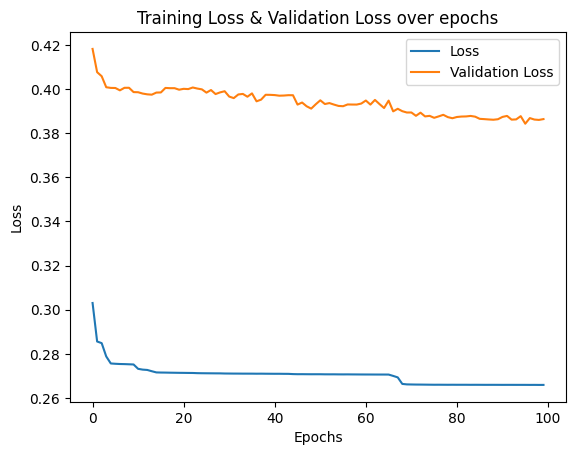

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Training Loss & Validation Loss over epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
#plt.ylim([0,.0008])
plt.legend(["Loss", "Validation Loss"])
plt.show()

In [14]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Tensor("anomaly_detector/sequential/dense_2/Relu:0", shape=(None, 8), dtype=float32)
Tensor("anomaly_detector/sequential_1/dense_5/Sigmoid:0", shape=(None, 46), dtype=float32)
2105/2105 [==============================] - 2s 989us/step
Threshold:  0.43404865


In [15]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(data, reconstructions) # 0 = anomaly (same as data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [16]:
%%timeit
%%capture

predict(autoencoder, np_test_data, threshold)

23.5 ms ± 1.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%%capture

test_predictions = predict(autoencoder, np_test_data, threshold)

### Stats for whole dataset

In [18]:
print_stats(test_predictions, test_labels)

Accuracy = 0.7363378282469837
Precision = 0.6248591315876699
Recall = 0.9706518381217176


In [19]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(test_labels, test_predictions))

[[7174 5659]
 [ 285 9426]]


In [20]:
test_labels_swap = []
for i in range(len(test_labels)):
    if test_labels[i]:
        test_labels_swap.append(False)
    else:
        test_labels_swap.append(True)

test_labels = test_labels_swap
np_test_labels = test_labels

### Stats for all predicted anomalous data

In [21]:
from pandas import DataFrame
from turtleIsolationForests.printResults import print_results

test_predictions_np = test_predictions.numpy()

autoec_predictions = DataFrame()

autoec_predictions['predicted_as_anomaly'] = test_predictions_np
autoec_predictions['is_normal'] = test_labels

print_results(autoec_predictions)

true anomalies: 9426
false anomalies: 5659
false normals: 285
true normals: 7174
precision: 0.6248591315876699
recall: 0.9706518381217176
f1-score: 0.7602839167607679


In [22]:
def addZToData(data, model):
    data_with_Z = []
    for i in range(1, len(data)+1):
        data_with_Z.append(addZToPrediction(model, data[i-1:i]))

    data_with_Z_rf = []
    for i in range(len(data_with_Z)):
        data_with_Z_rf.append(np.append(np_train_data[:][:][i].numpy().reshape(1,46).squeeze(), data_with_Z[i]))

    return pd.DataFrame(data_with_Z_rf)

In [23]:
train_data_with_Z_df = addZToData(np_train_data, autoencoder)

In [24]:
train_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,6.788234,2.396257,0.426340
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,5.030957,4.649899,0.240919
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.147187,4.531855,0.002381
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,2.860933,2.350209,0.707758
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.804795,1.926370,0.788824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,7.380088,4.536170,-0.030376
125969,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.944327,2.178603,0.680804
125970,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,6.999238,2.441846,0.597644
125971,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.420595,4.608039,-0.025003


In [25]:
np_test_labels = np.array(np_test_labels)

In [26]:
predicted_anomalous = np_test_data[test_predictions.numpy()]

In [27]:
train_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.280282,0.069972,-0.289103,-0.639532,-0.624871,-0.224532,-0.376387,6.788234,2.396257,0.426340
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,2.736852,2.367737,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,5.030957,4.649899,0.240919
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.147187,4.531855,0.002381
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.383108,0.066252,-0.572083,-0.602433,-0.387635,-0.345084,2.860933,2.350209,0.707758
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.804795,1.926370,0.788824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.121485,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,7.380088,4.536170,-0.030376
125969,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.386146,-0.447834,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.944327,2.178603,0.680804
125970,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.121485,-0.480197,-0.289103,0.979238,-0.624871,-0.355014,-0.376387,6.999238,2.441846,0.597644
125971,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.174417,-0.480197,-0.289103,1.608759,1.618955,-0.387635,-0.376387,8.420595,4.608039,-0.025003


In [28]:
predicted_anomalous_labels = np_test_labels[test_predictions.numpy()]

In [29]:
anomalous_test_data_with_Z_df = addZToData(predicted_anomalous, autoencoder)

In [30]:
contamination = sum(train_labels == 0) / len(train_labels)

In [31]:
# need test_predictions replaced at indices that autoencoder predicted anomalies

In [32]:
anomalous_test_data_with_Z_df

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.227350,1.493939,-0.111426,-0.639532,-0.624871,-0.387635,-0.376387,4.392317,2.629798,0.399301
1,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,2.756092,2.198385,-0.639532,-0.624871,-0.387635,-0.376387,4.787500,5.696764,0.267174
2,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.439078,-0.447834,-0.022587,-0.617049,-0.624871,-0.387635,-0.376387,2.859691,2.038686,0.756717
3,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,3.372038,-0.480197,-0.289103,-0.639532,-0.624871,1.961037,-0.251175,6.459633,5.691038,0.304314
4,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.447834,-0.022587,-0.639532,-0.624871,-0.387635,-0.376387,1.253655,1.928996,0.776313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15080,-0.019113,3.196020,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.439078,2.756092,-0.289103,-0.639532,-0.624871,-0.387635,-0.376387,0.623444,3.422799,0.530172
15081,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.121485,-0.447834,-0.200265,-0.617049,-0.624871,-0.387635,-0.376387,3.465312,2.150762,0.629530
15082,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,1.616978,-0.053906,-0.031767,-0.019726,-1.211901,...,-0.439078,-0.447834,-0.200265,-0.617049,-0.624871,-0.387635,-0.376387,1.961879,2.013232,0.761405
15083,-0.019113,-0.312889,-0.11205,-0.028606,-0.139982,-0.618438,-0.053906,-0.031767,-0.019726,0.825150,...,-0.439078,-0.480197,-0.289103,-0.639532,-0.624871,-0.159292,-0.157266,1.731618,2.150925,0.753762


In [33]:
def getFinalPredictions(first_predictions, second_predictions):
    f_p_copy = first_predictions.copy()
    s_p_copy = second_predictions.copy()
    indices = f_p_copy.index[f_p_copy["predicted_as_anomaly"] == True]
    s_p_copy.index = indices
    f_p_copy.loc[indices, "predicted_as_anomaly"] = s_p_copy["predicted_as_anomaly"]
    print_results(f_p_copy)
    print("auroc: " + str(get_auroc_value(f_p_copy)))

In [34]:
from turtleIsolationForests.extendedIsolationForest import ExtendedIsolationForest
from turtleIsolationForests.printResults import print_results
from turtleIsolationForests.printResults import get_auroc_value

eif = ExtendedIsolationForest(contamination = contamination, random_state = None)
eif.fit(train_data_with_Z_df, train_labels)

In [35]:
%%timeit

eif.predict(anomalous_test_data_with_Z_df)

38.7 s ± 547 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
eif_predictions = eif.predict(anomalous_test_data_with_Z_df)
eif_predictions['is_normal'] = predicted_anomalous_labels

#print_results(eif_predictions)
getFinalPredictions(autoec_predictions, eif_predictions)

true anomalies: 5691
false anomalies: 4411
false normals: 4020
true normals: 8422
precision: 0.5633537913284498
recall: 0.586036453506333
f1-score: 0.5744713067178115


KeyError: 'anomaly_score'

In [ ]:
train_predictions = eif.train_scores
train_predictions['is_normal'] = train_labels
print_results(train_predictions)

In [ ]:
from turtleIsolationForests.sciForest import SCIsolationForest

scif = SCIsolationForest(contamination = contamination, num_hyperplanes_per_split=5, random_state = None)
scif.fit(train_data_with_Z_df, train_labels)

In [ ]:
%%timeit

scif.predict(anomalous_test_data_with_Z_df)

In [ ]:
scif_predictions = scif.predict(anomalous_test_data_with_Z_df)
scif_predictions['is_normal'] = predicted_anomalous_labels

#print_results(scif_predictions)
getFinalPredictions(autoec_predictions, scif_predictions)

In [ ]:
from turtleIsolationForests.isolationForest import IsolationForest

isoforest = IsolationForest(contamination = contamination, random_state = None)
isoforest.fit(train_data_with_Z_df, train_labels)

In [ ]:
%%timeit

isoforest.predict(anomalous_test_data_with_Z_df)

In [ ]:
isoforest_predictions = isoforest.predict(anomalous_test_data_with_Z_df)
isoforest_predictions['is_normal'] = predicted_anomalous_labels

#print_results(isoforest_predictions)
getFinalPredictions(autoec_predictions, isoforest_predictions)

In [ ]:
from turtleIsolationForests.FBIF import FBIsolationForest

fbif = FBIsolationForest(contamination = contamination, random_state = None)
fbif.fit(train_data_with_Z_df, train_labels)

In [ ]:
%%timeit

fbif.predict(anomalous_test_data_with_Z_df)

In [ ]:
fbif_predictions = fbif.predict(anomalous_test_data_with_Z_df)
fbif_predictions['is_normal'] = predicted_anomalous_labels

#print_results(fbif_predictions)
getFinalPredictions(autoec_predictions, fbif_predictions)